#HAR_model_eval_defined_subj.ipynb
Uses the defined subject list from model_eval paper to separate the data into train, validation, test sets.

Author:  Lee B. Hinkle, IMICS Lab, Texas State University, 2021

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.


#Imports

In [11]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
import glob # to generate lists of files in directory - unix style pathnames
#from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from keras.utils import to_categorical # for one-hot encoding
import matplotlib.pyplot as plt # for plotting training curves
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
# to measure and display training time
import time
from datetime import timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [2]:
#Helpful functions especially inside colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    return my_name
#start output file with unique name - important for colab runs
def start_logfiles(base_name = "unnamed", first_line = "nothing here"):
    """creates file and writes colab environment info, returns full filename
    which is concatenation of path, base_name, and current UTC time"""
    result_dir = '/content/drive/My Drive/Colab_Run_Results'
    timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) #UTC time
    log_fname = base_name +'_'+timestamp
    full_log_fname = result_dir+'/'+log_fname+'.txt'
    print("Starting text logfile ",full_log_fname)
    with open(full_log_fname, "w") as file_object:
        header = first_line + '\n'
        header += full_log_fname +'\n'
        header += 'Generated by ' + what_is_my_name() + '\n'
        cpu_model = !grep 'model name' /proc/cpuinfo
        header += 'CPU1: ' + cpu_model[0] + '\n'
        header += 'CPU2: ' + cpu_model[1] + '\n'
        gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
        header += 'GPU: ' + str(gpu_info[1]) + '\n'
        file_object.write(header)
    return full_log_fname
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [3]:
DATASET = "MobiAct"


In [ ]:
DATASET = "UniMiB"

#Load the X, y, sub numpy arrays, drop component accel, one-hot encode y


In [6]:
if (DATASET == "MobiAct"):
    input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_20Hz_3s'
    ACT = ['JOG','JUM','STD','STN','STU','WAL']
    kernel_size = 20 # kernel is 1 second wide at 20Hz
    split_subj = {'train_subj':[2,4,5,9,10,16,18,20,23,24,26,27,28,32,34,35,
                                36,38,42,45,46,47,48,49,50,51,52,53,54,57],
                   'validation_subj':[3,6,8,11,12,22,37,40,43,56],
                   'test_subj':[7,19,21,25,29,33,39,41,44,55]}
elif (DATASET == "UniMiB"):
    input_dir = '/content/drive/MyDrive/Processed_Datasets/unimib_xys'
    ACT = ['A1','A2','A3','A4','A5','A6','A7','A8'] #need to check import str
    kernel_size = 50 # kernel is 1 second wide at 50Hz
    split_subj = {'train_subj':[4,5,6,7,8,10,11,12,14,15,19,20,21,22,24,26,27,29],
              'validation_subj':[1,9,16,23,25,28],
              'test_subj':[2,3,13,17,18,30]}
else:
    print ("Unknown or undefined DATASET")
    sys.exit("Unknown or undefined DATASET")

log_info = 'arrays loaded from'
log_info += input_dir + '\n'
X = np.load(input_dir + '/' + 'X.npy')
y = np.load(input_dir + '/' +'y.npy')
sub= np.load(input_dir + '/' +'sub.npy')
shapes = get_shapes([X,y,sub])
print ("Starting shape of loaded files")
print(shapes)

# Drop component acceleration
log_xyz = "Using total component accel, deleting accel_x/y/z from X\n"
X = np.delete(X, [0,1,2],2) # delete columns 1-3 along axis 2
log_info += log_xyz
print(get_shapes([X,y,sub]))

#One-Hot-Encode y...there must be a better way when starting with strings
#https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

if (y.shape[1]==1):
    # integer encode
    y_vector = np.ravel(y) #encoder won't take column vector
    le = LabelEncoder()
    integer_encoded = le.fit_transform(y_vector) #convert from string to int
    name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("One-hot-encoding: category names -> int -> one-hot")
    print(name_mapping)
    ACT = list(name_mapping) # keep activity names for conf matrix labels
    log_info += "One Hot:" + str(name_mapping) +"\n"
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print("One-hot-encoding",onehot_encoder.categories_)
    y=onehot_encoded
else:
    print ("y.shape[1] is not one, appears to be encoded already. Skipping")

print("\n",get_shapes([X,y,sub]))

Starting shape of loaded files
X shape is (13792, 60, 4) data type is float64
y shape is (13792, 1) data type is <U3
sub shape is (13792, 1) data type is int64

X shape is (13792, 60, 1) data type is float64
y shape is (13792, 1) data type is <U3
sub shape is (13792, 1) data type is int64

One-hot-encoding: category names -> int -> one-hot
{'JOG': 0, 'JUM': 1, 'STD': 2, 'STN': 3, 'STU': 4, 'WAL': 5}
One-hot-encoding [array([0, 1, 2, 3, 4, 5])]

 X shape is (13792, 60, 1) data type is float64
y shape is (13792, 6) data type is float64
sub shape is (13792, 1) data type is int64



#Split into pre-selected subjects 

In [7]:
#split by pre-selected subjects (original load data grouping)
method = "manual split using pre-selected subjects\n"
log_info += "Split: " + method

train_index = np.empty([1],dtype=int) #empty list
print("\nTrain Group adding subjects:", end =" ")
for my_sub in split_subj['train_subj']:
    print(my_sub, end =" ")
    #print(np.argwhere(sub == my_sub)[:,0])
    train_index = np.concatenate((train_index, np.argwhere(sub == my_sub)[:,0]))

validation_index = np.empty([1],dtype=int) #empty list
print("\nValidation Group adding subjects:", end =" ")
for my_sub in split_subj['validation_subj']:
    print(my_sub, end =" ")
    validation_index = np.concatenate((validation_index, np.argwhere(sub == my_sub)[:,0]))

test_index = np.empty([1],dtype=int) #empty list
print("\nTrain Group adding subjects:", end =" ")
for my_sub in split_subj['test_subj']:
    print(my_sub, end =" ")
    test_index = np.concatenate((test_index, np.argwhere(sub == my_sub)[:,0]))

print("\n")
#delete first row placeholders
train_index = np.delete(train_index, (0), axis=0) 
validation_index = np.delete(validation_index, (0), axis=0) 
test_index = np.delete(test_index, (0), axis=0)

X_train, X_test, X_validation = X[train_index], X[test_index], X[validation_index]
y_train, y_test, y_validation = y[train_index], y[test_index], y[validation_index]
new_shapes = get_shapes([X_train, y_train, X_validation, y_validation, X_test, y_test])
print (new_shapes)
log_info = log_info + new_shapes


Train Group adding subjects: 2 4 5 9 10 16 18 20 23 24 26 27 28 32 34 35 36 38 42 45 46 47 48 49 50 51 52 53 54 57 
Validation Group adding subjects: 3 6 8 11 12 22 37 40 43 56 
Train Group adding subjects: 7 19 21 25 29 33 39 41 44 55 

X_train shape is (8274, 60, 1) data type is float64
y_train shape is (8274, 6) data type is float64
X_validation shape is (2758, 60, 1) data type is float64
y_validation shape is (2758, 6) data type is float64
X_test shape is (2760, 60, 1) data type is float64
y_test shape is (2760, 6) data type is float64



# Function: evaluate_model builds and train Keras 1D CNN model

In [8]:
#def evaluate_model(trainX, trainy, validateX, validatey, testX, testy):
#different topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
def evaluate_model(trainX, trainy, validationX, validationy, 
                    BATCH_SIZE=16, NUM_EPOCHS=200,
                    my_filters = 50, my_kernel_size = 20):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential(
        [
        keras.Input(shape=(n_timesteps,n_features)),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ]
    )
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    start_time = time.time()
    history = model.fit(
        trainX,trainy,
        steps_per_epoch=trainX.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose = 0, #0 = silent, 1 = progress bar, 2 = one line per epoch.
        validation_data=(validationX,validationy),
        validation_steps=validationX.shape[1]//BATCH_SIZE)
    end_time = time.time()
    train_time = timedelta(seconds=(end_time - start_time))
    print('Training time =',(np.str(train_time).split(".")[0]), 'HH:MM:SS')
    model.save('my_1D_CNN_model')
    return history

#Function: run_model predicts using the test dataset

In [9]:
def run_model(testX, testy):
#this version broken with UniMiB
#if(False):
    model = keras.models.load_model('my_1D_CNN_model')
    start_time = time.time()
    predictions = model.predict(testX, verbose=0,batch_size=32)
    end_time = time.time()
    eval_time = timedelta(seconds=(end_time - start_time))
    print('Eval time =',(np.str(eval_time).split(".")[0]), 'HH:MM:SS')

    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test = np.argmax(testy, axis=-1)

    print(classification_report(y_test, y_pred, target_names=ACT))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    return (accuracy_score(y_test, y_pred)),y_pred, y_test

In [ ]:
#copied from stratification - one above gives error on UniMiB
def run_model(testX, testy):
    model = keras.models.load_model('my_1D_CNN_model')
    predictions = model.predict(testX, verbose=0,batch_size=32)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test = np.argmax(testy, axis=-1)
    return (accuracy_score(y_test, y_pred)),y_pred, y_test

#Loop using repeat value

Starting text logfile  /content/drive/My Drive/Colab_Run_Results/MobiAct_Def_Sub_Apr-16-2021_2105.txt
--- batch_size = 32 kernel_size = 20 num_epochs = 200

Pass number  1  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation Accuracy: 0.992


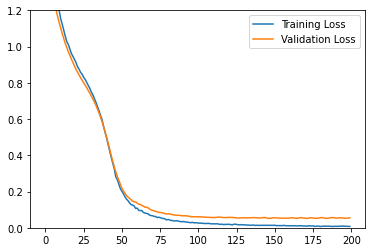

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.90      0.94       270
         JUM       0.95      0.99      0.97       270
         STD       1.00      1.00      1.00       990
         STN       0.81      0.85      0.83       120
         STU       0.95      0.90      0.92       120
         WAL       0.98      0.99      0.98       990

    accuracy                           0.97      2760
   macro avg       0.95      0.94      0.94      2760
weighted avg       0.98      0.97      0.97      2760

[[242  11   0  16   1   0]
 [  0 267   0   1   0   2]
 [  0   0 990   0   0   0]
 [  2   2   0 102   1  13]
 [  0   0   0   2 108  10]
 [  0   0   0   5   4 981]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.975
Pass number  2  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation 

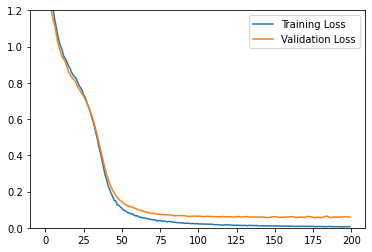

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.90      0.95       270
         JUM       0.97      0.97      0.97       270
         STD       1.00      1.00      1.00       990
         STN       0.72      0.88      0.79       120
         STU       0.92      0.90      0.91       120
         WAL       0.98      0.98      0.98       990

    accuracy                           0.97      2760
   macro avg       0.93      0.94      0.93      2760
weighted avg       0.97      0.97      0.97      2760

[[244   7   0  15   3   1]
 [  0 263   0   7   0   0]
 [  0   0 990   0   0   0]
 [  2   0   0 105   1  12]
 [  0   0   0   3 108   9]
 [  0   0   0  15   5 970]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  3  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation 

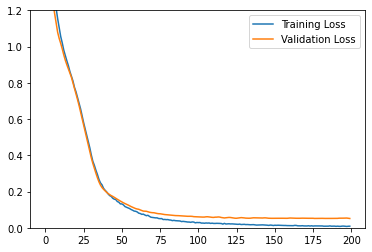

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.91      0.95       270
         JUM       0.99      0.96      0.98       270
         STD       1.00      1.00      1.00       990
         STN       0.61      0.87      0.72       120
         STU       0.95      0.91      0.93       120
         WAL       0.98      0.96      0.97       990

    accuracy                           0.96      2760
   macro avg       0.92      0.94      0.92      2760
weighted avg       0.97      0.96      0.97      2760

[[246   2   0  18   4   0]
 [  0 260   0   9   0   1]
 [  0   0 990   0   0   0]
 [  2   1   0 104   1  12]
 [  0   0   1   2 109   8]
 [  0   0   0  37   1 952]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.964
Pass number  4  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation 

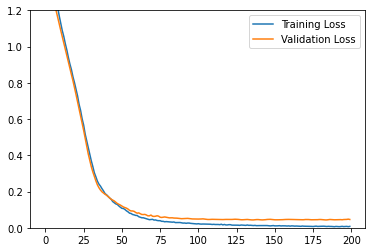

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.90      0.94       270
         JUM       0.96      1.00      0.98       270
         STD       1.00      1.00      1.00       990
         STN       0.77      0.87      0.82       120
         STU       0.96      0.94      0.95       120
         WAL       0.98      0.98      0.98       990

    accuracy                           0.98      2760
   macro avg       0.94      0.95      0.94      2760
weighted avg       0.98      0.98      0.98      2760

[[243  10   0  16   1   0]
 [  0 269   0   0   0   1]
 [  0   0 990   0   0   0]
 [  2   1   0 104   1  12]
 [  0   0   0   1 113   6]
 [  0   0   0  14   3 973]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.975
Pass number  5  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation 

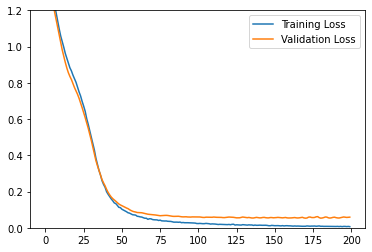

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.89      0.94       270
         JUM       0.95      0.97      0.96       270
         STD       1.00      1.00      1.00       990
         STN       0.61      0.84      0.71       120
         STU       0.91      0.93      0.92       120
         WAL       0.98      0.95      0.97       990

    accuracy                           0.96      2760
   macro avg       0.91      0.93      0.92      2760
weighted avg       0.97      0.96      0.96      2760

[[241  10   0  14   4   1]
 [  0 262   0   8   0   0]
 [  0   0 989   0   0   1]
 [  2   5   0 101   1  11]
 [  0   0   0   3 111   6]
 [  0   0   0  39   6 945]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.960
Pass number  6  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation 

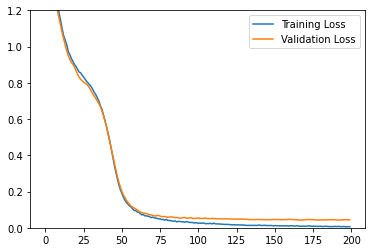

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.92      0.95       270
         JUM       0.98      0.96      0.97       270
         STD       1.00      1.00      1.00       990
         STN       0.70      0.87      0.78       120
         STU       0.95      0.92      0.93       120
         WAL       0.98      0.98      0.98       990

    accuracy                           0.97      2760
   macro avg       0.93      0.94      0.94      2760
weighted avg       0.97      0.97      0.97      2760

[[248   3   0  16   3   0]
 [  0 260   0  10   0   0]
 [  0   0 989   0   0   1]
 [  2   1   0 104   1  12]
 [  0   0   0   1 110   9]
 [  0   0   0  17   2 971]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.972
Pass number  7  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation 

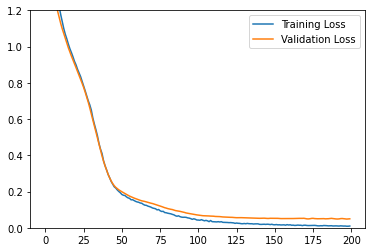

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.93      0.96       270
         JUM       0.95      0.98      0.97       270
         STD       1.00      1.00      1.00       990
         STN       0.80      0.86      0.83       120
         STU       0.89      0.90      0.90       120
         WAL       0.98      0.98      0.98       990

    accuracy                           0.97      2760
   macro avg       0.94      0.94      0.94      2760
weighted avg       0.97      0.97      0.97      2760

[[250  11   0   7   2   0]
 [  0 265   0   5   0   0]
 [  0   0 989   0   0   1]
 [  2   3   0 103   1  11]
 [  0   0   0   3 108   9]
 [  0   0   0  11  10 969]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.972
Pass number  8  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation 

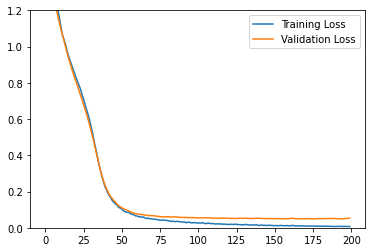

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.89      0.94       270
         JUM       0.92      0.96      0.94       270
         STD       1.00      1.00      1.00       990
         STN       0.73      0.82      0.77       120
         STU       0.95      0.93      0.94       120
         WAL       0.98      0.98      0.98       990

    accuracy                           0.97      2760
   macro avg       0.93      0.93      0.93      2760
weighted avg       0.97      0.97      0.97      2760

[[240  19   0  10   1   0]
 [  0 260   0   9   0   1]
 [  0   0 989   0   0   1]
 [  2   5   0  99   1  13]
 [  0   0   0   2 112   6]
 [  0   0   0  16   4 970]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.967
Pass number  9  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation 

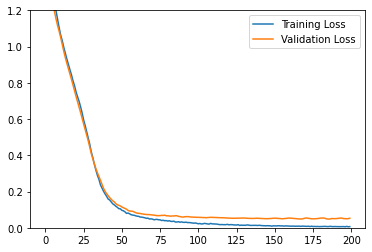

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.89      0.94       270
         JUM       0.96      0.99      0.98       270
         STD       1.00      1.00      1.00       990
         STN       0.64      0.85      0.73       120
         STU       0.91      0.97      0.94       120
         WAL       0.99      0.96      0.97       990

    accuracy                           0.97      2760
   macro avg       0.92      0.94      0.93      2760
weighted avg       0.97      0.97      0.97      2760

[[239   5   0  22   3   1]
 [  0 267   0   3   0   0]
 [  0   0 989   0   0   1]
 [  2   5   0 102   1  10]
 [  0   0   0   2 117   1]
 [  0   0   0  30   8 952]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.966
Pass number  10  of  10
Training time = 0:00:10 HH:MM:SS
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:11
manual split using pre-selected subjects
 
Validation

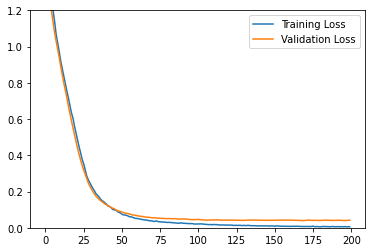

Eval time = 0:00:00 HH:MM:SS
              precision    recall  f1-score   support

         JOG       0.99      0.91      0.95       270
         JUM       0.97      0.97      0.97       270
         STD       1.00      1.00      1.00       990
         STN       0.74      0.87      0.80       120
         STU       0.83      0.93      0.88       120
         WAL       0.97      0.96      0.97       990

    accuracy                           0.97      2760
   macro avg       0.92      0.94      0.93      2760
weighted avg       0.97      0.97      0.97      2760

[[245   7   0  12   3   3]
 [  0 263   0   6   0   1]
 [  0   0 989   0   0   1]
 [  2   1   0 104   0  13]
 [  0   0   0   1 111   8]
 [  0   0   0  18  19 953]]
Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.966
Training time,0:00:11,0:00:11,0:00:11,0:00:11,0:00:11,0:00:11,0:00:11,0:00:11,0:00:11,0:00:11
 Validation accuracy,0.992,0.992,0.993,0.992,0.991,0.992,0.991,0.991,0.993,0.992
 Prediction time,0:00:00,0:

In [12]:
#Training Params
BATCH_SIZE = 32
NUM_EPOCHS = 200
#kernel size is set to 1s right after DATABASE is selected
log_full_fname = start_logfiles(base_name=DATASET+'_Def_Sub',
                                first_line='Defined Subject ' + DATASET)

pass_info = "--- batch_size = " + str(BATCH_SIZE)
pass_info += " kernel_size = " + str(kernel_size)
pass_info += " num_epochs = " + str(NUM_EPOCHS) + "\n"
print (pass_info)
with open(log_full_fname, "a") as file_object:
    file_object.write(log_info)
    file_object.write(pass_info)
repeats = 10;
#for my_split in my_full_list:
for i in range(1):
    for repeat_num in range(repeats):  #rerun current config
        print("Pass number ", repeat_num + 1, " of ",repeats)
        start_time = time.time()
        history = evaluate_model(X_train, y_train, X_validation, y_validation,
                                 BATCH_SIZE, NUM_EPOCHS, my_filters = 50, 
                                 my_kernel_size = kernel_size)
        end_time = time.time()
        training_time = str(timedelta(seconds=(end_time - start_time))).split('.', 2)[0]
        print('Training time HH:MM:SS = ',training_time)
        print(method, "\nValidation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
        #Plot the training and validation loss
        fig = plt.figure()
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.ylim([0,1.2]) #set limit - 1.2 has been a good value experimentally
        plt.show()
        #Now run trained model against test set
        start_time = time.time()
        #Need to sort this out - returned arrays are re-encoded, but error
        acc = run_model(X_test, y_test)
        end_time = time.time()
        predict_time = str(timedelta(seconds = (end_time - start_time))).split('.', 2)[0]
        print('Prediction time HH:MM:SS = ',predict_time)
        print('Prediction accuracy: {0:.3f}'.format(acc[0]))
        #col_sep = '&' # for import as LaTeX table
        #end_line = '\\\\ \\hline\n' # end of table row with underline for latex
        col_sep = ',' # for csv
        end_line = '\n' # for csv
        if (repeat_num == 0):
            train_time = 'Training time'+ col_sep + training_time
            val_acc = 'Validation accuracy'+ col_sep +'%0.3f' % history.history['val_accuracy'][-1]
            pred_time = 'Prediction time' + col_sep + predict_time
            pred_acc = 'Prediction accuracy' + col_sep + '{0:.3f}'.format(acc[0])
            run_acc = acc[0] #total acc for quick avg calc
        else:
            train_time += col_sep + training_time
            val_acc += col_sep + '%0.3f' % history.history['val_accuracy'][-1]
            pred_time += col_sep + predict_time
            pred_acc += col_sep + '{0:.3f}'.format(acc[0])
            run_acc += acc[0]
    train_time += end_line
    val_acc += end_line
    pred_time += end_line
    pred_acc += col_sep + "Avg = " + col_sep + '{0:.3f}'.format(run_acc/repeats)+ end_line
    print (train_time, val_acc, pred_time, pred_acc)
    with open(log_full_fname, "a") as file_object:
            file_object.write(train_time)
            file_object.write(val_acc)
            file_object.write(pred_time)
            file_object.write(pred_acc)